# 06 Spotify Data Regression Analysis 2.0 

## The goal of this regression is to look at how total tracks played relates to the total minutes played  

## 01 Importing Libraries and Data 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
import os 

In [2]:
%matplotlib inline 

In [3]:
path = '/Users/brookecoffey/Desktop/DataAnalyticsTy/Achievement 6 /Spotify Project'

In [4]:
df = pd.read_pickle(os.path.join(path, '01 Data', '02 Prepared Data', 'df_6.pkl'))

## 02 Data Cleaning 
### Remove Podcast Data  

In [5]:
df.shape

(172116, 28)

In [6]:
df.columns

Index(['ts', 'platform', 'ms_played', 'conn_country',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped_x', 'offline', 'latitude',
       'longitude', 'region', 'minutes_seconds', 'year', 'month',
       'day_of_week', 'hour_of_day', 'skipped_ratio', 'skip_prob', 'count_y',
       'listening_frequency'],
      dtype='object')

In [7]:
df['listening_frequency'].value_counts()

Above Average Frequency    42591
Highest Frequency          42246
Medium Frequency           41344
Low Frequency              30095
Only Played Once           13206
NaN                         2634
Name: listening_frequency, dtype: int64

In [8]:
df = df[df['listening_frequency'] != 'NaN']

In [9]:
df['listening_frequency'].value_counts()

Above Average Frequency    42591
Highest Frequency          42246
Medium Frequency           41344
Low Frequency              30095
Only Played Once           13206
Name: listening_frequency, dtype: int64

In [10]:
df.shape

(169482, 28)

In [11]:
# Effectively removed podcast episodes

In [12]:
# Import datetime to manipulate timestamp data into weekly aggregates
import datetime

In [13]:
# Grouping total track and time played data into weekly format 

In [14]:
# Group by week and count the total number of tracks played in each week
tracks_played = df.groupby(pd.Grouper(key='ts', freq='W')).size()

# Group by week and sum the milliseconds played in each week
ms_played = df.groupby(pd.Grouper(key='ts', freq='W'))['ms_played'].sum()

# Concatenate the two Series into a single DataFrame
result_df = pd.concat([tracks_played, ms_played], axis=1)
result_df.columns = ['Total Tracks Played', 'Total Milliseconds Played']

# Display the aggregated data with week
print(result_df)

            Total Tracks Played  Total Milliseconds Played
ts                                                        
2012-07-22                  289                    4888728
2012-07-29                    6                      19594
2012-08-05                   21                    2211644
2012-08-12                    4                     335259
2012-08-19                   65                    5859256
...                         ...                        ...
2023-07-30                  579                   49525838
2023-08-06                  265                   65626116
2023-08-13                  367                   61990298
2023-08-20                  592                   82483378
2023-08-27                  545                   42746412

[580 rows x 2 columns]


In [15]:
# turning milliseconds into minutes for easier scaling 
result_df['minutes_played'] = result_df['Total Milliseconds Played'] / 60000

In [16]:
result_df

Total Tracks Played  Total Milliseconds Played  minutes_played
ts                                                                        
2012-07-22                  289                    4888728       81.478800
2012-07-29                    6                      19594        0.326567
2012-08-05                   21                    2211644       36.860733
2012-08-12                    4                     335259        5.587650
2012-08-19                   65                    5859256       97.654267
...                         ...                        ...             ...
2023-07-30                  579                   49525838      825.430633
2023-08-06                  265                   65626116     1093.768600
2023-08-13                  367                   61990298     1033.171633
2023-08-20                  592                   82483378     1374.722967
2023-08-27                  545                   42746412      712.440200

[580 rows x 3 columns]

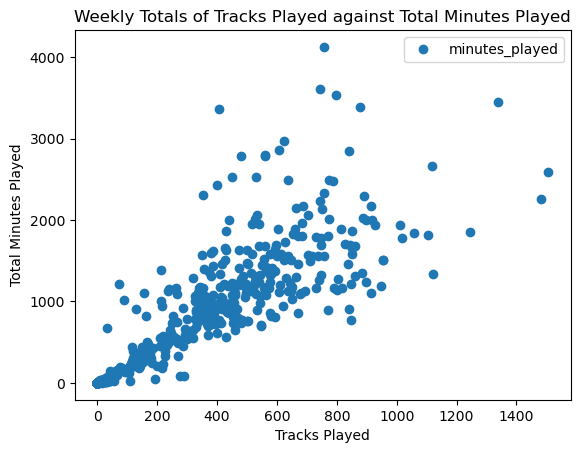

In [17]:
# Plotting relationship
result_df.plot(x = 'Total Tracks Played', y = 'minutes_played', style='o')
plt.title('Weekly Totals of Tracks Played against Total Minutes Played')
plt.xlabel('Tracks Played')
plt.ylabel('Total Minutes Played')
plt.show()

In [18]:
result_df.describe()

Total Tracks Played  Total Milliseconds Played  minutes_played
count           580.000000               5.800000e+02      580.000000
mean            292.210345               4.260489e+07      710.081449
std             301.471298               4.631229e+07      771.871459
min               0.000000               0.000000e+00        0.000000
25%               0.000000               0.000000e+00        0.000000
50%             236.000000               3.312598e+07      552.099717
75%             500.000000               7.093780e+07     1182.296713
max            1506.000000               2.475926e+08     4126.543883

### Missing Values

In [19]:
result_df.isnull().sum()

# No missing values

Total Tracks Played          0
Total Milliseconds Played    0
minutes_played               0
dtype: int64

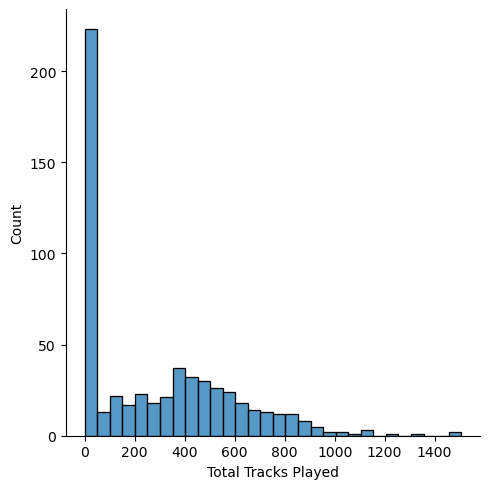

In [20]:
sns.displot(result_df['Total Tracks Played'], bins=30)

In [21]:
# Despite the extreme frequency of low-duration plays, I think I 
# need to leave this unchanged for now and can revisit after the initial regression

## Duplicates Check 

In [22]:
dups = result_df.duplicated()

In [23]:
dups.shape # No duplicates 

(580,)

## 03 Data Prep for regression analysis

In [24]:
# Create a scatterplot to plot variables against each other 

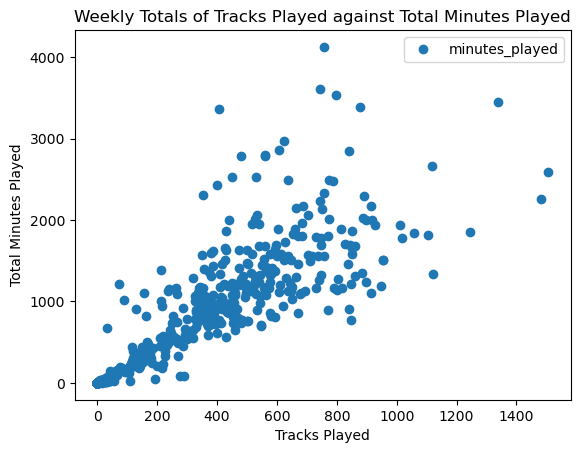

In [25]:
result_df.plot(x = 'Total Tracks Played', y = 'minutes_played', style='o')
plt.title('Weekly Totals of Tracks Played against Total Minutes Played')
plt.xlabel('Tracks Played')
plt.ylabel('Total Minutes Played')
plt.show()

# Hypothesis: As the total tracks played increases, so will the total minutes played 

In [26]:
# Reshape variables into Numpy arrays 
X = result_df['Total Tracks Played'].values.reshape(-1,1)
y = result_df['minutes_played'].values.reshape(-1,1)

In [27]:
X

array([[ 289],
       [   6],
       [  21],
       [   4],
       [  65],
       [ 285],
       [   6],
       [  44],
       [  32],
       [   4],
       [  64],
       [ 120],
       [   2],
       [ 135],
       [  65],
       [ 237],
       [ 483],
       [ 143],
       [ 111],
       [ 221],
       [ 152],
       [ 385],
       [ 233],
       [ 268],
       [ 158],
       [ 138],
       [ 153],
       [ 181],
       [ 119],
       [ 257],
       [ 111],
       [ 125],
       [ 119],
       [ 106],
       [  50],
       [ 105],
       [ 216],
       [  85],
       [ 132],
       [  19],
       [  40],
       [   0],
       [   0],
       [   0],
       [   0],
       [  15],
       [   1],
       [  26],
       [  29],
       [   7],
       [   2],
       [  13],
       [   0],
       [   8],
       [  93],
       [   5],
       [ 133],
       [  30],
       [   6],
       [  22],
       [ 187],
       [ 199],
       [ 218],
       [  22],
       [  37],
       [ 107],
       [  

In [28]:
y

array([[8.14788000e+01],
       [3.26566667e-01],
       [3.68607333e+01],
       [5.58765000e+00],
       [9.76542667e+01],
       [4.55191383e+02],
       [2.03300167e+01],
       [6.18226000e+01],
       [6.74882500e+01],
       [8.17926667e+00],
       [1.40495617e+02],
       [3.02073617e+02],
       [3.58321667e+00],
       [2.78659700e+02],
       [1.08106200e+02],
       [5.44561133e+02],
       [7.68808417e+02],
       [2.04094900e+02],
       [2.28198483e+02],
       [5.52702867e+02],
       [3.85492967e+02],
       [9.73736483e+02],
       [5.29651317e+02],
       [3.24763150e+02],
       [3.84264900e+02],
       [1.83900817e+02],
       [2.53987183e+02],
       [2.40880033e+02],
       [2.12198767e+02],
       [5.26328700e+02],
       [2.32646467e+02],
       [2.13386583e+02],
       [2.56483583e+02],
       [1.92366633e+02],
       [1.21735967e+02],
       [1.53545200e+02],
       [1.86657317e+02],
       [1.48920233e+02],
       [2.42196450e+02],
       [3.35948500e+01],


In [29]:
# Split data into a training set and a test set 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

# 04 Regression Analysis 

In [30]:
# Create a regression object. 
regression = LinearRegression()

In [31]:
# Fit the regression object onto the training set 
regression.fit(X_train, y_train)

LinearRegression()

In [32]:
# Predict the values of y using X.
y_predicted = regression.predict(X_test)

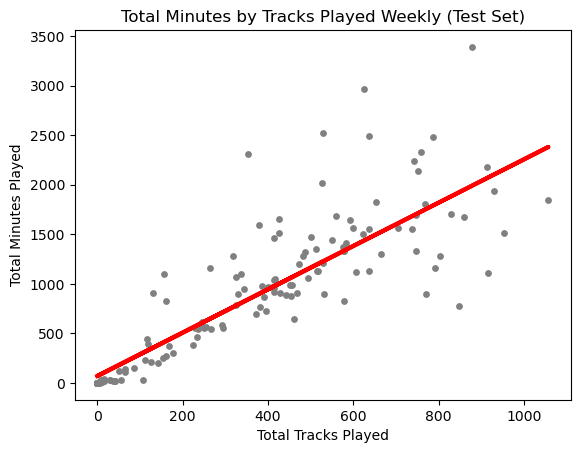

In [33]:
# Create a plot that shows the regression line from the model 

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s=15)
plot_test.plot(X_test, y_predicted, color='red', linewidth=3)
plot_test.title('Total Minutes by Tracks Played Weekly (Test Set)')
plot_test.xlabel('Total Tracks Played')
plot_test.ylabel('Total Minutes Played')
plot_test.show()

# The line appears to fit the set very well, there are a few outliers on either end, but it generally fits the trend well with large clusters of points around the trend line

# 05 Test Set Summary Statistics

In [34]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [35]:
print('Slope:' ,regression.coef_)
print('Mean squared error:', rmse)
print('R2 score:' , r2)

Slope: [[2.18527781]]
Mean squared error: 122617.8371226921
R2 score: 0.7809864358138345


In [36]:
y_predicted

array([[1223.68874288],
       [1000.79040661],
       [ 150.71733984],
       [1394.1404118 ],
       [ 981.12290635],
       [1232.42985411],
       [  69.86206099],
       [ 780.07734814],
       [  91.71483906],
       [1092.57207449],
       [  69.86206099],
       [  69.86206099],
       [1754.71124989],
       [  69.86206099],
       [ 627.10790168],
       [ 972.38179512],
       [ 922.12040557],
       [1459.698746  ],
       [ 133.23511739],
       [ 911.19401654],
       [  69.86206099],
       [1057.60762958],
       [1328.5820776 ],
       [ 946.15846144],
       [1066.34874081],
       [  69.86206099],
       [ 179.12595133],
       [ 900.26762751],
       [1365.73180031],
       [ 410.76539883],
       [  69.86206099],
       [  69.86206099],
       [ 976.75235074],
       [ 561.54956748],
       [ 974.56707293],
       [1433.47541232],
       [  69.86206099],
       [1190.90957578],
       [ 192.23761816],
       [1002.97568442],
       [  87.34428345],
       [ 904.638

In [37]:
data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

Actual    Predicted
0   1210.911733  1223.688743
1   1508.672983  1000.790407
2     24.014617   150.717340
3   1119.574033  1394.140412
4   1043.645817   981.122906
5    897.638817  1232.429854
6      0.000000    69.862061
7   1065.389200   780.077348
8     32.971033    91.714839
9    907.355533  1092.572074
10     0.000000    69.862061
11     0.000000    69.862061
12   895.852317  1754.711250
13     0.000000    69.862061
14   560.250383   627.107902
15  1033.413433   972.381795
16   870.534117   922.120406
17  1129.720483  1459.698746
18    32.234967   133.235117
19   973.736483   911.194017
20     0.000000    69.862061
21   985.818050  1057.607630
22  1370.691117  1328.582078
23   972.441917   946.158461
24   987.575867  1066.348741
25     0.000000    69.862061
26   121.735967   179.125951
27  1590.853417   900.267628
28  1639.994867  1365.731800
29  1099.796200   410.765399

## Looking at the dataframe above comparing actual values against predicted values, it seems that there are wider variances than expected, but some were also very close considering the scale of the data 

In [38]:
#exporting data 
result_df.to_pickle(os.path.join(path, '01 Data', '02 Prepared Data', 'regression.pkl'))

In [39]:
result_df.to_csv((os.path.join(path, '01 Data', '02 Prepared Data', 'regression.csv')))

In [40]:
df.to_pickle((os.path.join(path, '01 Data', '02 Prepared Data', 'no_podcasts.pkl')))